# Rock-paper-scissors with Keras/TensorFlow (DCT Type-II / DNN)

Date: January 9, 2019

Classification:
- rock
- paper
- scissors

## Preparing data set for DNN

In [52]:
DATA_FOLDER = '../thermography/data/'

FILES = 45
TRAINING_FILES = 30 
TEST_FILES = FILES - TRAINING_FILES

In [53]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp
from scipy.fftpack import dct, idct

In [54]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            training_set.append((data, class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            test_set.append((data, class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


(array([ 3.35890638e-02,  5.42458535e-01, -3.81855543e+00, -4.33574610e-01,
         5.63543965e-01, -4.08725259e-02,  3.66250799e+00, -4.74748809e-01,
        -1.74139046e+00,  3.43014454e-01,  1.51101483e-01,  2.08296271e-01,
        -1.20096494e+00, -7.11784301e-01,  4.23983556e-01,  9.46336610e-01,
         1.73671333e-01, -1.20755766e-01,  4.05306124e-02,  4.84261299e-01,
         2.32335603e-01,  1.46947676e-01, -1.77545726e-02, -2.09835300e-01,
        -7.00334028e-02,  1.65713527e-01,  1.92415674e-01, -4.45207036e-02,
         1.02200287e-03,  1.73319536e-01,  1.43241928e-01, -2.48754885e-02,
        -2.09709409e-01, -2.16677095e-02,  3.92018686e-01,  1.20733622e-01]),
 array([0., 0., 1.], dtype=float32))

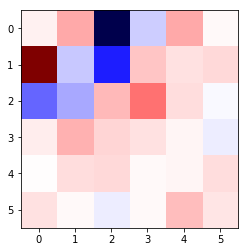

In [55]:
CUTOFF=6
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    img = img.reshape(8,8)
    img = dct(dct(img, norm='ortho').T, norm='ortho').T
    img[0,0] = 0
    img = img[:CUTOFF,:CUTOFF].flatten()
    img = pp.scale(img)    
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    img = img.reshape(8,8)
    img = dct(dct(img, norm='ortho').T, norm='ortho').T
    img[0,0] = 0
    img = img[:CUTOFF,:CUTOFF].flatten()
    img = pp.scale(img)
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data)
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data)
test_lables = np.array(test_labels, dtype='uint8')

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12].reshape((CUTOFF,CUTOFF)), cmap='seismic')
train_data[12], train_labels[12]

### DNN model

In [56]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Dense(int(CUTOFF**2*1.5), activation='relu', input_shape=(CUTOFF**2,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(int(CUTOFF**2*1.5), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 54)                1998      
_________________________________________________________________
dropout_7 (Dropout)          (None, 54)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 54)                2970      
_________________________________________________________________
dropout_8 (Dropout)          (None, 54)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 165       
Total params: 5,133
Trainable params: 5,133
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

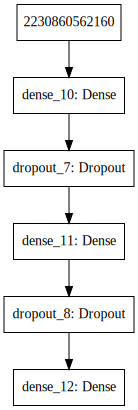

In [58]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training DNN

In [59]:
EPOCHS = 130
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 90 samples, validate on 45 samples
Epoch 1/130
90/90 [==============================] - 0s 5ms/step - loss: 1.5561 - acc: 0.2778 - val_loss: 1.1469 - val_acc: 0.2889
Epoch 2/130
90/90 [==============================] - 0s 89us/step - loss: 1.3673 - acc: 0.2222 - val_loss: 1.1112 - val_acc: 0.3556
Epoch 3/130
90/90 [==============================] - 0s 78us/step - loss: 1.2558 - acc: 0.4000 - val_loss: 1.0733 - val_acc: 0.4000
Epoch 4/130
90/90 [==============================] - 0s 89us/step - loss: 1.2819 - acc: 0.3444 - val_loss: 1.0429 - val_acc: 0.4667
Epoch 5/130
90/90 [==============================] - 0s 78us/step - loss: 1.3030 - acc: 0.3000 - val_loss: 1.0152 - val_acc: 0.5111
Epoch 6/130
90/90 [==============================] - 0s 89us/step - loss: 1.1337 - acc: 0.3778 - val_loss: 0.9952 - val_acc: 0.5111
Epoch 7/130
90/90 [==============================] - 0s 78us/step - loss: 1.1584 - acc: 0.4222 - val_loss: 0.9661 - val_acc: 0.6000
Epoch 8/130
90/90 [==============

90/90 [==============================] - 0s 111us/step - loss: 0.4823 - acc: 0.8333 - val_loss: 0.2482 - val_acc: 0.9556
Epoch 63/130
90/90 [==============================] - 0s 100us/step - loss: 0.3427 - acc: 0.8333 - val_loss: 0.2425 - val_acc: 0.9556
Epoch 64/130
90/90 [==============================] - 0s 100us/step - loss: 0.4110 - acc: 0.8444 - val_loss: 0.2371 - val_acc: 0.9556
Epoch 65/130
90/90 [==============================] - 0s 111us/step - loss: 0.3624 - acc: 0.8889 - val_loss: 0.2301 - val_acc: 0.9556
Epoch 66/130
90/90 [==============================] - 0s 89us/step - loss: 0.3963 - acc: 0.8444 - val_loss: 0.2275 - val_acc: 0.9556
Epoch 67/130
90/90 [==============================] - 0s 100us/step - loss: 0.3249 - acc: 0.9333 - val_loss: 0.2227 - val_acc: 0.9556
Epoch 68/130
90/90 [==============================] - 0s 100us/step - loss: 0.4061 - acc: 0.8556 - val_loss: 0.2229 - val_acc: 0.9556
Epoch 69/130
90/90 [==============================] - 0s 89us/step - loss: 0

90/90 [==============================] - 0s 89us/step - loss: 0.1937 - acc: 0.9333 - val_loss: 0.1324 - val_acc: 0.9778
Epoch 124/130
90/90 [==============================] - 0s 177us/step - loss: 0.1980 - acc: 0.9444 - val_loss: 0.1347 - val_acc: 0.9778
Epoch 125/130
90/90 [==============================] - 0s 144us/step - loss: 0.1609 - acc: 0.9444 - val_loss: 0.1386 - val_acc: 0.9778
Epoch 126/130
90/90 [==============================] - 0s 133us/step - loss: 0.2288 - acc: 0.9444 - val_loss: 0.1322 - val_acc: 0.9778
Epoch 127/130
90/90 [==============================] - 0s 144us/step - loss: 0.1327 - acc: 0.9778 - val_loss: 0.1330 - val_acc: 0.9778
Epoch 128/130
90/90 [==============================] - 0s 155us/step - loss: 0.1731 - acc: 0.9444 - val_loss: 0.1351 - val_acc: 0.9778
Epoch 129/130
90/90 [==============================] - 0s 210us/step - loss: 0.2221 - acc: 0.9222 - val_loss: 0.1347 - val_acc: 0.9778
Epoch 130/130
90/90 [==============================] - 0s 166us/step -

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


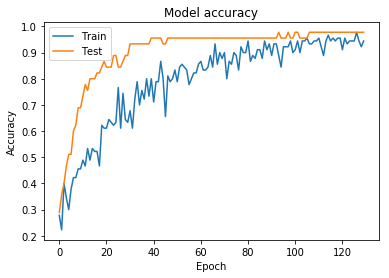

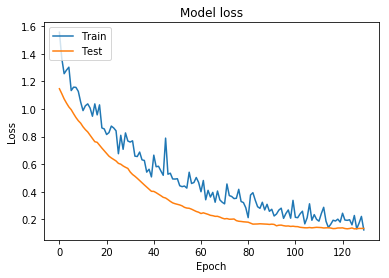

In [60]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [61]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'rock_paper_scissors_dct_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [62]:
del model
model = models.load_model(filename)

## Confirmation

In [63]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(90, 36)

In [64]:
layer_outputs = [layer.output for layer in model.layers]

In [65]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)

In [66]:
class_labels

['paper', 'rock', 'scissors']

In [67]:
(activations[-1][:10]*100).astype(int)

array([[ 0, 99,  0],
       [ 2,  0, 96],
       [ 0, 99,  0],
       [96,  2,  1],
       [54,  5, 40],
       [97,  0,  1],
       [ 0,  0, 99],
       [99,  0,  0],
       [ 2,  0, 97],
       [99,  0,  0]])

In [68]:
test_labels[:10].astype(int)

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])